# Pipeline 01: BAS lifecycle analysis

**Plate description**:\
Plate 85\
A5 SP3\
Crossdate: 06/07

**Experience description**\
We took close up images of 40 BAS of the plate to determine the extend of septation of each of these BAS.
We then use this positions to extract images from all timesteps from Prince image to determine the age of each BAS and their growing curve.
The prince images range from 

## Setup

### Imports

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
from amftrack.util.sys import (
    get_current_folders,
    update_plate_info,
    test_path
)
import pandas as pd
from amftrack.util.plot import show_image

/home/ipausers/kahane/Wks/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from amftrack.util.sys import storage_path
from amftrack.util.geometry import generate_index_along_sequence, centered_bounding_box

In [3]:
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    Node,
    Edge,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    plot_edge_width,
    plot_full,
)

In [231]:
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    plot_hulls_skelet,
    plot_full,
    reconstruct_image_from_general,
)
from amftrack.util.video_util import make_video_targeted

### General parameters

In [128]:
directory = "/gpfs/work1/0/einf914/data" + "/"
plate_name = "20220330_2357_Plate19"

### Experiment object setup

In [129]:
update_plate_info(directory)
folder_df = get_current_folders(directory)

analysed:   0%|          | 0/2444 [00:00<?, ?it/s]

In [130]:
folder_df['Plate'].unique()

array(['1015', '1023', '30', '1076', '1044', '23', '1047', '1045', '1033',
       '86', '12', '1048', '6', '1040', '27', '1070', '21', '33'],
      dtype=object)

In [131]:
select = folder_df[folder_df['Plate']=='86']

In [132]:
len(select)

163

In [133]:
len(select.head(30))

30

Only load part of the timesteps

In [134]:
exp = Experiment(directory)
exp.load(select.head(30), suffix="")

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2022-06-23 00:07:00
2022-06-23 02:07:00
2022-06-23 03:07:00
2022-06-23 21:16:00
2022-06-24 03:16:00
2022-06-24 08:16:00
2022-06-24 09:17:00
2022-06-24 16:05:00
2022-06-25 06:31:00
2022-06-25 16:31:00
2022-06-26 04:31:00
2022-06-26 20:31:00
2022-06-27 02:31:00
2022-06-27 10:31:00
2022-06-27 14:12:00
2022-06-27 16:24:00
2022-06-29 05:07:00
2022-06-29 13:30:00
2022-06-30 01:38:00
2022-06-30 07:37:00
2022-06-30 15:44:00
2022-07-02 05:33:00
2022-07-03 03:34:00
2022-07-03 11:34:00
2022-07-03 17:33:00
2022-07-03 19:33:00
2022-07-05 00:46:00
2022-07-05 08:45:00
2022-07-05 17:46:00
2022-07-05 22:29:00


Finding first and last steps

In [135]:
pd.set_option('display.max_rows', 500)
select['date'].sort_values()

2328    01.07.2022, 01:22:
2197    01.07.2022, 03:22:
2022    01.07.2022, 05:22:
1314    01.07.2022, 07:22:
1078    01.07.2022, 09:22:
1886    01.07.2022, 11:33:
1047    01.07.2022, 13:34:
688     01.07.2022, 15:34:
1983    01.07.2022, 19:33:
834     01.07.2022, 21:33:
483     01.07.2022, 23:34:
2102    02.07.2022, 01:34:
2165    02.07.2022, 03:34:
202     02.07.2022, 05:33:
2157    02.07.2022, 07:33:
615     02.07.2022, 09:33:
1057    02.07.2022, 11:34:
988     02.07.2022, 13:34:
1529    02.07.2022, 15:34:
2005    02.07.2022, 17:33:
1953    02.07.2022, 19:33:
1677    02.07.2022, 21:33:
529     02.07.2022, 23:34:
1879    03.07.2022, 01:34:
37      03.07.2022, 03:34:
1816    03.07.2022, 05:34:
2158    03.07.2022, 07:33:
440     03.07.2022, 09:33:
128     03.07.2022, 11:34:
2141    03.07.2022, 13:34:
1162    03.07.2022, 15:34:
307     03.07.2022, 17:33:
57      03.07.2022, 19:33:
1456    03.07.2022, 21:34:
1887    03.07.2022, 23:34:
1758    04.07.2022, 01:34:
1906    04.07.2022, 03:34:
9

In [136]:
last_row = folder_df.iloc[1503]
first_row = folder_df.iloc[479]

In [137]:
index_list = [479,1503]
extreme_df = folder_df.loc[folder_df.index[index_list]]

## 0/ General visualisation of the plate

### Full plate at the end

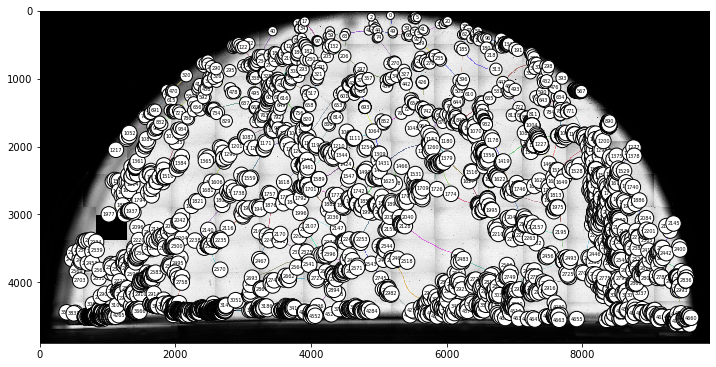

In [51]:
#%matplotlib inline
t = 29
exp.load_tile_information(t)
plot_full_image_with_features(exp, t, downsizing = 5, dilation = 10, edges = get_all_edges(exp, t), nodes = get_all_nodes(exp, t))

### Full plate at the start

2022-06-22 18:07:00
2022-07-06 06:29:00


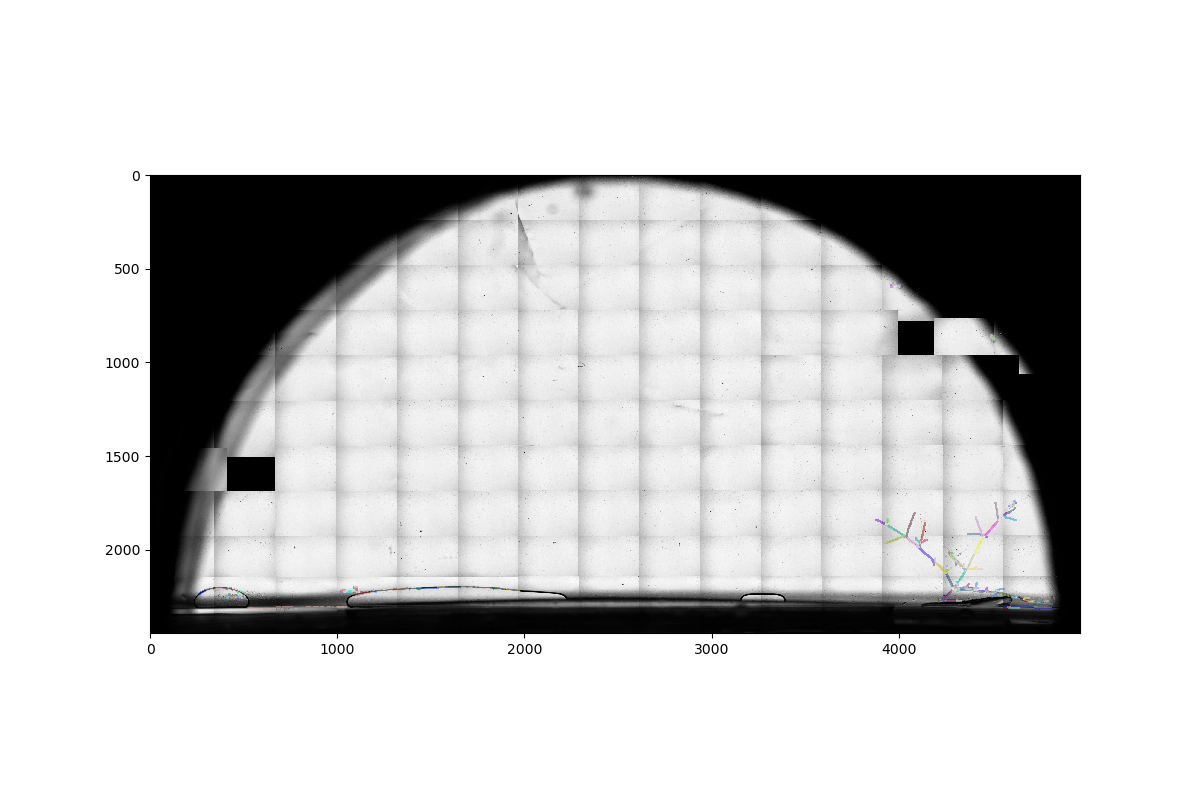

In [40]:
exp_first = Experiment(directory)
exp_first.load(extreme_df, suffix="")
t = 0
exp_first.load_tile_information(t)
plot_full_image_with_features(exp_first, t, downsizing = 10, dilation = 10, edges = get_all_edges(exp_first, t))

### Skeletonization check

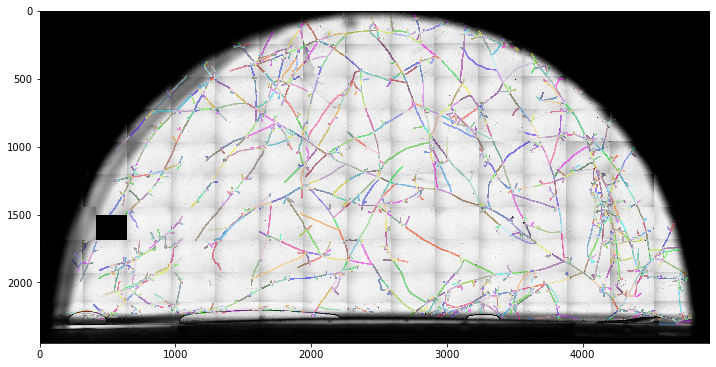

In [75]:
t = 29
exp.load_tile_information(t)
plot_full_image_with_features(exp, t, downsizing = 10, dilation = 10, edges = get_all_edges(exp, t))

## 1/ Bas groundtruth coordinates

#### Original coordinates in joystick setup

In [101]:
groundtruths = [[62880, 36780],
    [62580, 35200],
    [62000, 33020],
    [61140, 33580],
    [61120, 31240],
    [60700, 30840],
    [58740, 29860],
    [58700, 30240],
    [58260, 30960],
    [56780, 29320],
    [56320, 30020],
    [56080, 31300],
    [55460, 31320],
    [55920, 27280],
    [55260, 27620],
    [55680, 26480],
    [55980, 26280],
    [53220, 28780],
    [56020, 24780],
    [55060, 25040],
    [48680, 16600],
    [47360, 15340],
    [44540, 18320],
    [40040, 11940],
    [38860, 11260],
    [29520, 15960],
    [31420, 10020],
    [28220, 12600],
    [26240, 17120],
    [26240, 17460],
    [26240, 18060],
    [26240, 18400],
    [7100, 29300],
    [5860, 30180],
    [4540, 24080],
    [5960, 23540],
    [8560, 21360],
    [13520, 20200],
    [17300, 23540],
    [29160, 34780],
    [29980, 33920],
    [29980, 33920],
    [33260, 32700], 
    [41540, 33880],
    [45420, 34820],
    [44040, 36780],
    [46220, 36740],
    [45380, 37560],
    [50480, 40120],
    [52600, 39480],
    [55320, 38700],
    [37640, 22180],
    [35080, 21500],
    [34800, 21500],
    [19000, 40440],
    [20160, 29740],
    [14600, 39000],
    [19560, 31360],
    [19560, 31360],
    [18400, 33960],
    [30200, 21280],
    [47360, 24600]
    ]

In [102]:
len(groundtruths)

62

#### Boundaries of the plate in joystick setup

In [117]:
boundaries = [[0, 45120], [3140, 19140], [29100, 8860], [54540, 17720], [69340, 45120]]

#### Transform coordinates

In [118]:
def reverse_coords(l):
    return [[a[1], a[0]] for a in l]

In [119]:
groundtruths = reverse_coords(groundtruths)
boundaries = reverse_coords(boundaries)

#### Check points repartition

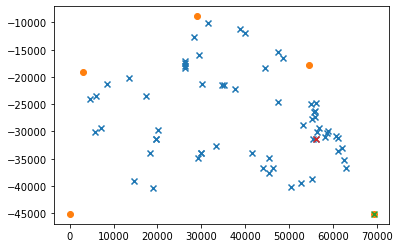

In [158]:
%matplotlib inline
xs = [-a[0] for a in groundtruths]
ys = [a[1] for a in groundtruths]
xs_b = [-a[0] for a in boundaries]
ys_b = [a[1] for a in boundaries]
plt.scatter(ys, xs, marker = "x")
plt.scatter(ys_b, xs_b, marker = "o")
plt.scatter([69340], [-45120], marker = "x")
i = 11
plt.scatter([ys[i]], [xs[i]], marker = "x")
plt.show()

#### Finding corresponding point

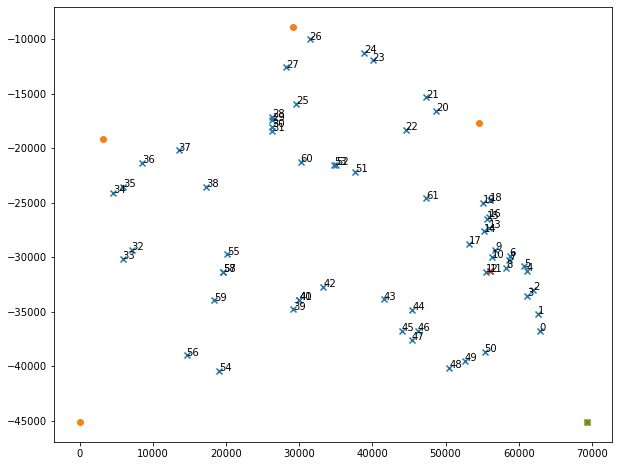

In [168]:
import matplotlib.transforms as mtransforms
%matplotlib inline
plt.figure(figsize=(10,8))
xs = [-a[0] for a in groundtruths]
ys = [a[1] for a in groundtruths]
xs_b = [-a[0] for a in boundaries]
ys_b = [a[1] for a in boundaries]
plt.scatter(ys, xs, marker = "x")
plt.scatter(ys_b, xs_b, marker = "o")
plt.scatter([69340], [-45120], marker = "x")
i = 11
plt.scatter([ys[i]], [xs[i]], marker = "x")

for i, (x, y) in enumerate(zip(xs, ys)):
    plt.text(y, x, f'{i+1}')

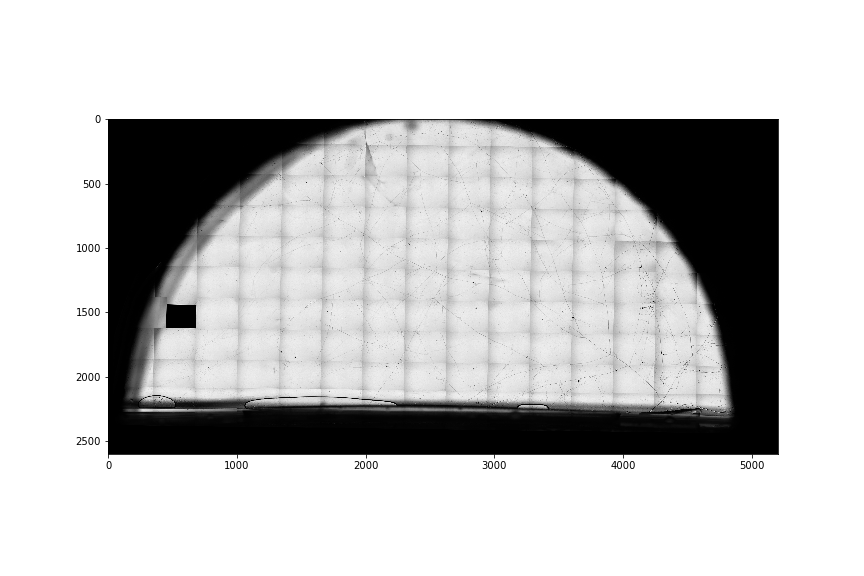

In [174]:
%matplotlib widget
t = 29
exp.load_tile_information(t)
plot_full(exp, t, downsizing = 10, region = [[0, 0], [26000, 52000]])

#### Find transformation to general coordinates

In [201]:
def find_scaling_factor(old_coord_list, new_coord_list):
    n = len(old_coord_list)
    values = []
    for i in range(n):
        for j in range(i+1, n):
            print(f"{i},{j}")
            dx = np.linalg.norm(np.array(old_coord_list[i]) - np.array(old_coord_list[j]))
            dfx = np.linalg.norm(np.array(new_coord_list[i]) - np.array(new_coord_list[j]))
            values.append(dfx / dx)
    print(values)
    return np.median(values)

In [215]:
find_scaling_factor(joystick_coord_reversed, general_coord)

0,1
0,2
0,3
0,4
1,2
1,3
1,4
2,3
2,4
3,4
[0.993569905987049, 1.0203167964192639, 0.7203109191050446, 1.0000840681924619, 0.9993589260585032, 1.0743227733038896, 0.9914675400605822, 1.3259267182382135, 1.0039464728701888, 1.000329790555873]


1.0002069293741673

In [216]:
from amftrack.util.image_analysis import find_transformation, get_transformation

In [217]:
joystick_coord = [[19000, 40440], [37640, 22180], [17300, 23540], [14600, 35000], [52600, 39480]]
plt_coord = [[1982, 1740], [3142, 771], [1955, 730], [1719, 1609], [3940, 1825]]

In [218]:
joystick_coord_reversed = np.array(reverse_coords(joystick_coord))*0.583
general_coord = np.array(reverse_coords(plt_coord))*10

In [219]:
R, t = find_transformation(joystick_coord_reversed, general_coord)

In [220]:
f = get_transformation(R, t)

In [221]:
def rev(c):
    return [c[1], c[0]]

In [222]:
f_tot = lambda x: f(np.array(rev(x))*0.583)

In [225]:
f_tot_ = lambda x: f(np.array(x)*0.583) 

In [223]:
f_tot([52600, 39480])

array([18234.98872326, 39490.30304923])

In [224]:
general_coord

array([[17400, 19820],
       [ 7710, 31420],
       [ 7300, 19550],
       [16090, 17190],
       [18250, 39400]])

#### Test the transformation

In [227]:
c = f_tot_(groundtruths[30])
c

array([ 5106.57996044, 24665.88851002])

In [234]:
groundtruths_general = [f_tot_(c) for c in groundtruths]
groundtruths_general.insert(0,[0, 0]) # to have matching indexes with my notes

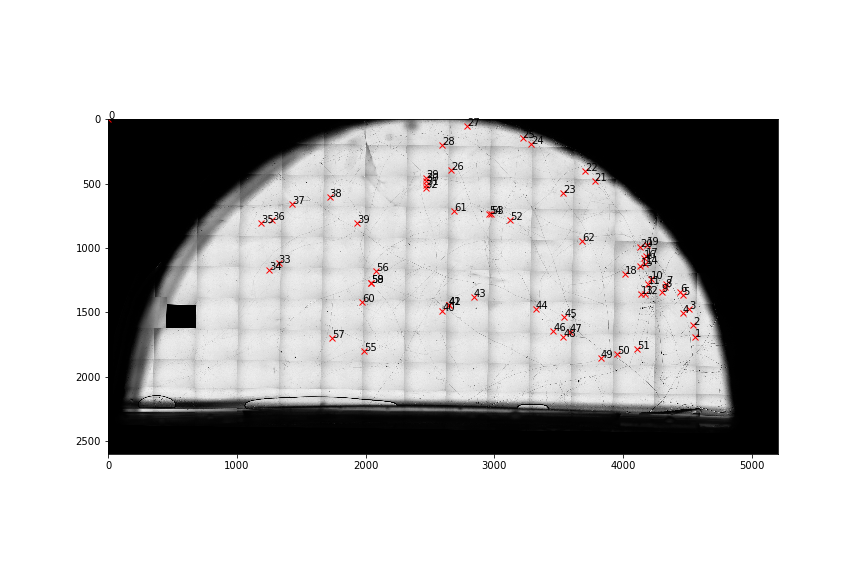

In [235]:
# %matplotlib inline
%matplotlib widget
t = 29
exp.load_tile_information(t)
plot_full(exp, t, downsizing = 10, region = [[0, 0], [26000, 52000]], points = groundtruths_general, with_point_label = True)

In [238]:
groundtruths_general_plt = [
    [4478, 1640],
    [4502, 1530],
    [4445, 1400],
    [4400, 1430],
    [4416, 1310],
    [4384, 1280],
    [4267, 1221],
    [4300, 1248],
    [4249, 1268],
    [4194, 1202],
    [4169, 1212],
    [4138, 1277],
    [4121, 1338],
    [4177, 1056],
    [4108, 1076],
    [4133, 1000],
    [4130, 1034],
    [3984, 1153],
    [4130, 917],
    [4098, 960],
    [3800, 424],
    [3702, 383],
    [3529, 565],
    [3290, 169],
    [3208, 120],
    [2665, 347],
    [2822, 28],
    [2556, 158],
    [2431, 382],
    [2422, 440],
    [2443, 471],
    [2403, 542],
    [1392, 971],
    [1287, 1020],
    [1225, 661],
    [1332, 672],
    [1475, 542],
    [1753, 504],
    [1955, 730],
    [2545, 1433],
    [2645, 1394],
    [2635, 1364],
    [2850, 1317],
    [3322, 1439],
    [3510, 1517],
    [3416, 1572],
    [3571, 1623],
    [3523, 1664],
    [3782, 1776],
    [3945, 1827],
    [4095, 1807],
    [3121, 746],
    [3122, 705],
    [3079, 728],
    [1970, 1735],
    [2023, 1114],
    [1697, 1600],
    [1995, 1208],
    [1977, 1204],
    [1977, 1273],
    [2861, 679],
    [3711, 988],
]

In [239]:
f = lambda c: np.array([c[1], c[0]])*10

In [240]:
groundtruths_general = [f(c) for c in groundtruths_general_plt]

#### Find the right coordinates for each point

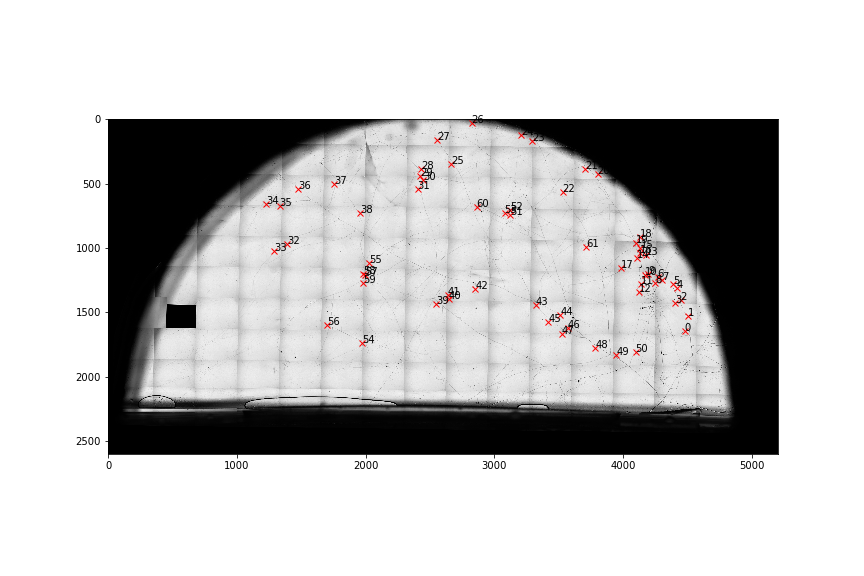

In [241]:
# %matplotlib inline
%matplotlib widget
t = 29
exp.load_tile_information(t)
plot_full(exp, t, downsizing = 10, region = [[0, 0], [26000, 52000]], points = groundtruths_general, with_point_label = True)

In [242]:
groundtruths_general

[array([16400, 44780]),
 array([15300, 45020]),
 array([14000, 44450]),
 array([14300, 44000]),
 array([13100, 44160]),
 array([12800, 43840]),
 array([12210, 42670]),
 array([12480, 43000]),
 array([12680, 42490]),
 array([12020, 41940]),
 array([12120, 41690]),
 array([12770, 41380]),
 array([13380, 41210]),
 array([10560, 41770]),
 array([10760, 41080]),
 array([10000, 41330]),
 array([10340, 41300]),
 array([11530, 39840]),
 array([ 9170, 41300]),
 array([ 9600, 40980]),
 array([ 4240, 38000]),
 array([ 3830, 37020]),
 array([ 5650, 35290]),
 array([ 1690, 32900]),
 array([ 1200, 32080]),
 array([ 3470, 26650]),
 array([  280, 28220]),
 array([ 1580, 25560]),
 array([ 3820, 24310]),
 array([ 4400, 24220]),
 array([ 4710, 24430]),
 array([ 5420, 24030]),
 array([ 9710, 13920]),
 array([10200, 12870]),
 array([ 6610, 12250]),
 array([ 6720, 13320]),
 array([ 5420, 14750]),
 array([ 5040, 17530]),
 array([ 7300, 19550]),
 array([14330, 25450]),
 array([13940, 26450]),
 array([13640, 2

## 2 Make movies

In [48]:
make_video_targeted(exp, coordinate=[4675, 24500], directory_path=os.path.join(directory, 'BAS', 'test'), size=600)

['/gpfs/work1/0/einf914/data/BAS/test/20220623-0007.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220623-0207.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220623-0307.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220623-2116.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220624-0316.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220624-0816.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220624-0917.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220624-1605.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220625-0631.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220625-1631.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220626-0431.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220626-2031.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220627-0231.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220627-1031.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220627-1412.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220627-1624.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220629-0507.png',
 '/gpfs/work1/

In [93]:
res = ['/gpfs/work1/0/einf914/data/BAS/test/20220623-0007.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220623-0207.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220623-0307.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220623-2116.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220624-0316.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220624-0816.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220624-0917.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220624-1605.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220625-0631.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220625-1631.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220626-0431.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220626-2031.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220627-0231.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220627-1031.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220627-1412.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220627-1624.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220629-0507.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220629-1330.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220630-0138.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220630-0737.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220630-1544.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220702-0533.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220703-0334.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220703-1134.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220703-1733.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220703-1933.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220705-0046.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220705-0845.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220705-1746.png',
 '/gpfs/work1/0/einf914/data/BAS/test/20220705-2229.png']

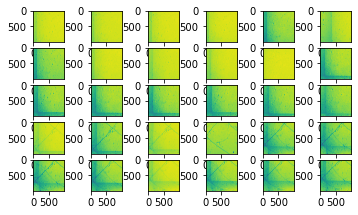

In [108]:
%matplotlib inline
for i in range(30):
    plt.subplot(6, 6, i+1)
    show_image(res[i])

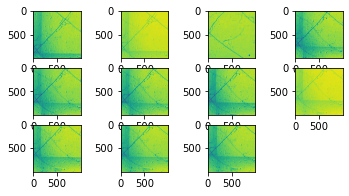

In [109]:
%matplotlib inline
for i in range(19, 30):
    plt.subplot(4, 4, i-18)
    show_image(res[i])

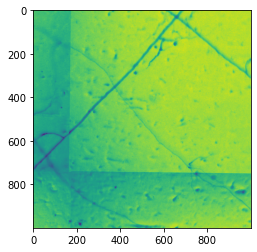

In [112]:
show_image(res[25])

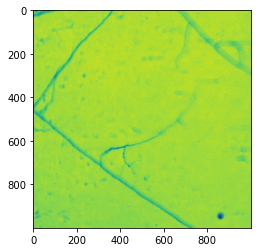

In [110]:
show_image(res[21])

## 2/ Choosing BAS on the last image

Not using the last image but one of the last

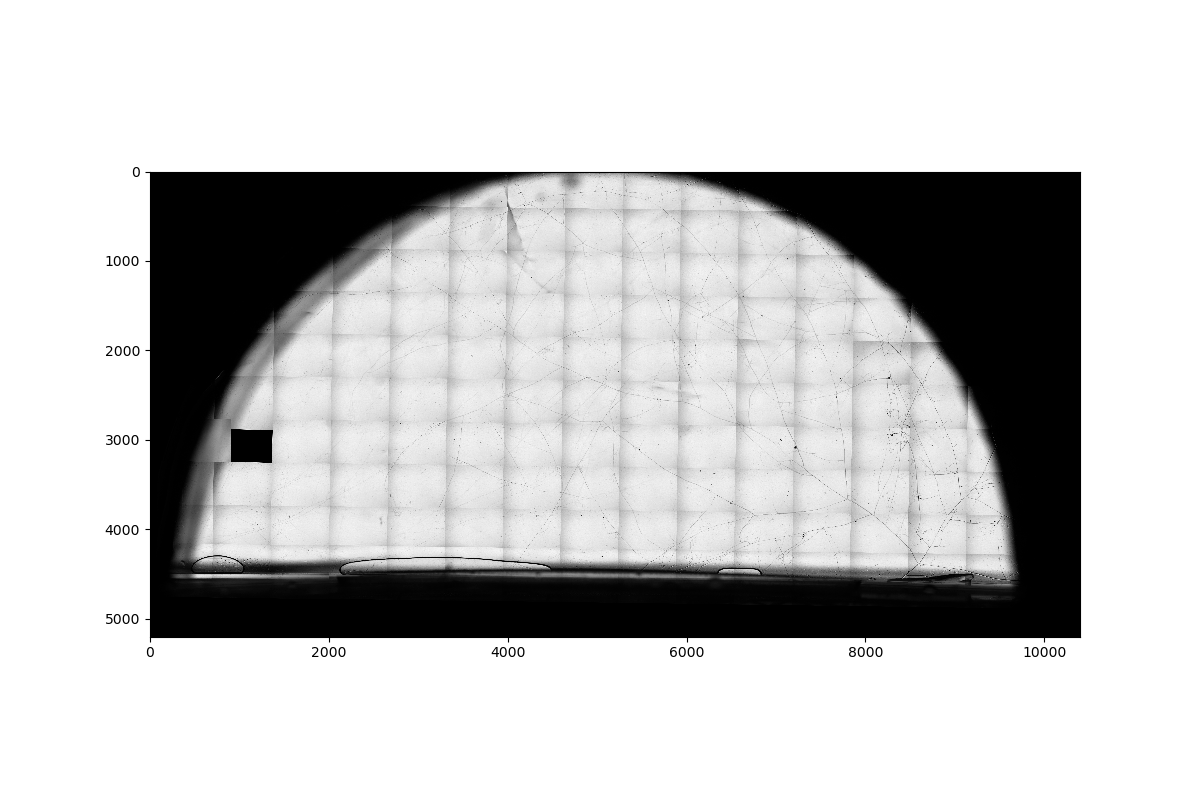

In [25]:
# %matplotlib inline
t = 29
exp.load_tile_information(t)
plot_full(exp, t, downsizing = 5, region = [[0, 0], [26000, 52000]])

In [29]:
bas_coords_plt = [
    [4900, 935],
    [4815, 1080],
    [4925, 1945],
    [5730, 1370],
    [6240, 1420],
    [5410, 920],
    [7085, 1120],
    [7420, 1965],
    [7300, 1835],
    [7780, 1835],
    [7640, 1485],
    [7990, 2310],
    [8240, 2155],
    [7485, 2510],
    [7660, 2680],
    [8400, 2370],
    [8350, 2845],
    [7685, 2890],
    [6865, 3150],
    [7025, 3040],
    [7230, 3025],
    [7245, 3110],
    [7145, 3250],
    [6480, 3960],
    [6810, 4110],
    [6580, 4285],
    [6245, 4000],
    [6065, 4145],
    [7410, 4110],
    [7890, 3680],
    [7900, 3900],
    [8185, 3620],
    [8250, 3900],
    [8570, 4165],
    [7040, 4115]
]

In [30]:
bas_coords_general = [np.array([coord[1], coord[0]])*5 for coord in bas_coords_plt]
bas_coords_general

[array([ 4675, 24500]),
 array([ 5400, 24075]),
 array([ 9725, 24625]),
 array([ 6850, 28650]),
 array([ 7100, 31200]),
 array([ 4600, 27050]),
 array([ 5600, 35425]),
 array([ 9825, 37100]),
 array([ 9175, 36500]),
 array([ 9175, 38900]),
 array([ 7425, 38200]),
 array([11550, 39950]),
 array([10775, 41200]),
 array([12550, 37425]),
 array([13400, 38300]),
 array([11850, 42000]),
 array([14225, 41750]),
 array([14450, 38425]),
 array([15750, 34325]),
 array([15200, 35125]),
 array([15125, 36150]),
 array([15550, 36225]),
 array([16250, 35725]),
 array([19800, 32400]),
 array([20550, 34050]),
 array([21425, 32900]),
 array([20000, 31225]),
 array([20725, 30325]),
 array([20550, 37050]),
 array([18400, 39450]),
 array([19500, 39500]),
 array([18100, 40925]),
 array([19500, 41250]),
 array([20825, 42850]),
 array([20575, 35200])]

## 3/ Visualize selected BAS

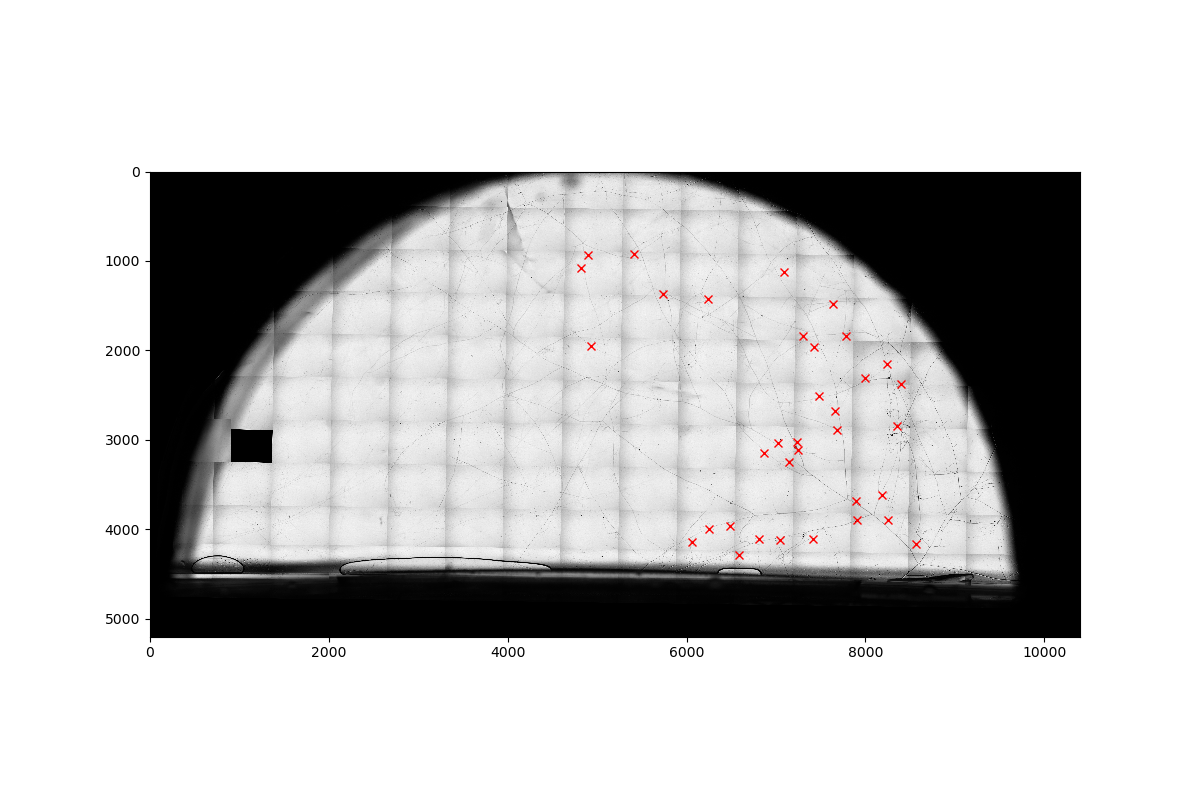

In [35]:
# %matplotlib inline
t = 29
exp.load_tile_information(t)
plot_full(exp, t, downsizing = 5, region = [[0, 0], [26000, 52000]], points = bas_coords_general)

## 4/ Extract movies for each BAS

In [243]:
from amftrack.pipeline.launching.run_super import run_parallel_all_time,run_launcher
from amftrack.util.formatting import coord_list_to_str, str_to_coord_list

In [244]:
directory = "/gpfs/work1/0/einf914/data/"

In [245]:
update_plate_info(directory)
folder_df = get_current_folders(directory)

analysed:   0%|          | 0/2444 [00:00<?, ?it/s]

In [246]:
folder_df['Plate'].unique()

array(['1015', '1023', '30', '1076', '1044', '23', '1047', '1045', '1033',
       '86', '12', '1048', '6', '1040', '27', '1070', '21', '33'],
      dtype=object)

In [247]:
select = folder_df[folder_df['Plate']=='86']

In [248]:
len(select)

163

In [249]:
num_parallel = 1
time = '120:00'
args = [directory, coord_list_to_str(groundtruths_general), 1500, True, False]
run_parallel_all_time(
    "make_video_targeted.py",
    args,
    select,
    num_parallel,
    time,
    "make_video_felix_gr",
    cpus=32,
    node="fat",
    dependency=False,
    name_job="felix_video_gr.sh",
)

In [33]:
len(select)

164

## Brouillon

In [40]:
from amftrack.util.plot import make_random_color

In [74]:
def convert(c):
    c_ = c/255
    return (c_[0], c_[1], c_[2])

In [117]:
def plot_nuancier(n = 10):
    im = np.full((1, n, 4), fill_value = 1)
    for i in range(n):
        im[0, i, :] = make_random_color((i))
    plt.imshow(im)

In [70]:
convert(make_random_color(1))

(34, 145, 216)

<IPython.core.display.Javascript object>


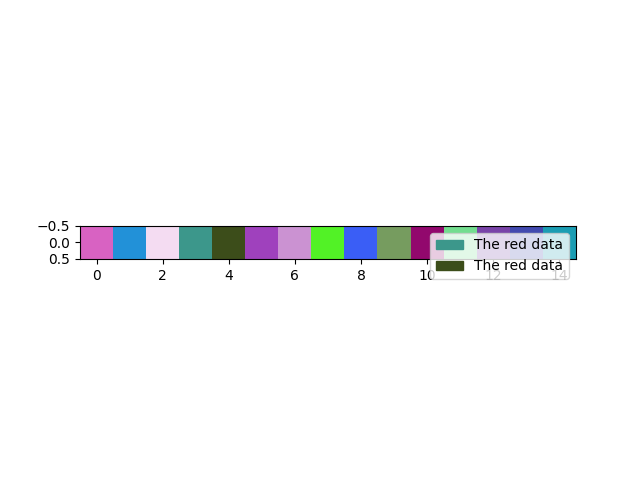

In [116]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
red_patch1 = mpatches.Patch(color=convert(make_random_color(3)), label='The red data')
red_patch2 = mpatches.Patch(color=convert(make_random_color(4)), label='The red data')
ax.legend(handles=[red_patch1, red_patch2])

plt.show()